In [1]:
%matplotlib inline
from netCDF4 import Dataset
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from spharm import Spharmt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
cmap = ListedColormap(sns.color_palette("coolwarm", 9).as_hex())
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 0.6

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = 'line'
matplotlib.rcParams['axes.labelsize'] = 7

matplotlib.rcParams['grid.linestyle'] = '-.'
matplotlib.rcParams['grid.linewidth'] = 0.4

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 0.7

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.7


In [2]:
nlons = 72
nlats = 36
grid = Spharmt(nlons,nlats,gridtype='regular',rsphere=3371e3)


[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j]


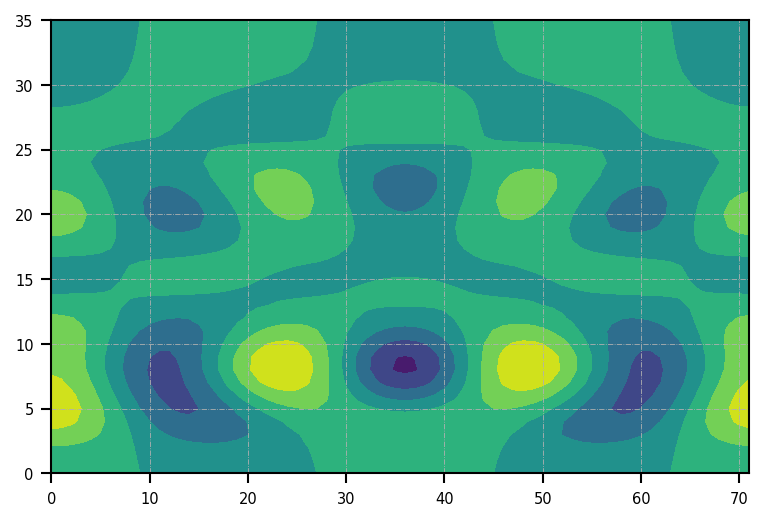

In [3]:
s = grid.grdtospec(np.zeros((nlats,nlons)), ntrunc=10)
print(s)
s[:]=0.
s[25:35]=np.random.random(10)
contourf(grid.spectogrd(s))
# grid.grdtospec?

[  31  700 1369 2038 2707 3376 4045 4714]
[  31  700 1369 2038 2707 3376 4045 4714 5383 6052]
[ 586 1258 1931]


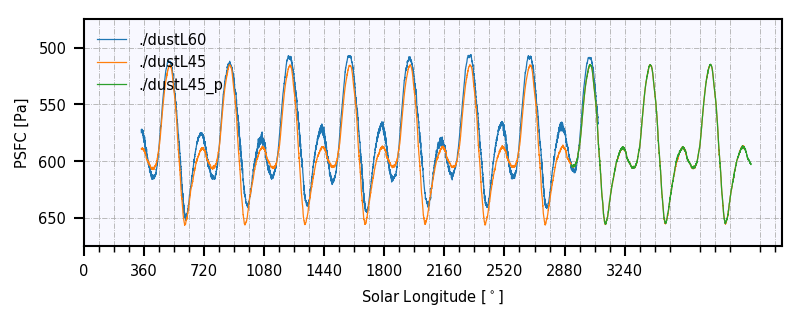

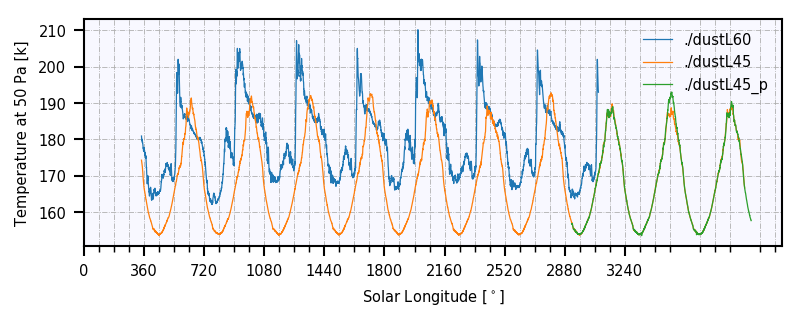

In [4]:
from netCDF4 import Dataset

major_ticks = np.arange(0, 360*10, 360)  

def yearly_ls(ls):
    idx = np.where(ls==360)[0]
    print (idx)
    counter = 1
    for i in np.arange(idx.size-1):
        ls[idx[i]:idx[i+1]] += counter*360
        ls[idx[i]] -= 360
        counter += 1
    ls[idx[i+1]:] += counter*360
    ls[idx[i+1]] -= 360
    return ls

# wet data
filedir = './wet_test.nc'
data = Dataset(filedir,'r')
psfcwet = data.variables['PSFC'][:]
twet = data.variables['T'][:][:,25:30].mean(axis=1)
ls = data.variables['LS'][:]
ls = yearly_ls(ls)

# dust data
filedir = './dust_test.nc'
data = Dataset(filedir,'r')
psfcdust = data.variables['PSFC'][:]
tdust = data.variables['T'][:][:,25:30].mean(axis=1)
lsdust = data.variables['LS'][:]
lsdust = yearly_ls(lsdust)

# dust perturbation high res scale
filedir = './dust_pert_test.nc'
data = Dataset(filedir,'r')
psfcdustp = data.variables['PSFC'][:]
tdustp = data.variables['T'][:][:,25:30].mean(axis=1)
lsdustp = data.variables['LS'][:]
lsdustp = yearly_ls(lsdustp) + 2880
# print (np.where(lsdust==lsdustp[0]), 'test')
# lsdust = lsdust[:6690]

full_arr = 2000
fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], psfcwet[:], label='./dustL60')
plot(lsdust[:], psfcdust, label='./dustL45')
plot(lsdustp[:],psfcdustp, label='./dustL45_p')
ylabel('PSFC [Pa]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
# xlim([2880,3960])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
ylim([675,475])
legend()

fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], twet[:], label='./dustL60')
plot(lsdust[:],tdust, label='./dustL45')
plot(lsdustp[:],tdustp, label='./dustL45_p')
ylabel('Temperature at 50 Pa [k]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
# xlim([2880,3960])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
legend()


In [56]:
filedir = './dust_pert_test.nc'
data = Dataset(filedir,'r')
lsdustp = data.variables['LS'][:]#[:1931-593]

filedir = './dust_test.nc'
data = Dataset(filedir,'r')
lsdust = data.variables['LS'][:][:6690]

filedir = './wet_test.nc'
data = Dataset(filedir,'r')
ls = data.variables['LS'][:][:4714-31]

print (np.diff(np.where(lsdustp==360)[0]), lsdustp.shape)
print (np.diff(np.where(lsdust==360)[0]), lsdust.shape)
print (np.where(ls==360), ls.shape)

def find_idx_period(ls, period,i):
    idx = np.where(abs(ls-(i*period+period/2))<period/2)[0]
    print(idx)
    if np.where(np.diff(idx)>1)[0].size == 1:
        print(np.where(np.diff(idx)>1)[0])
        size_period = np.where(np.diff(idx)>1)[0][0] + 1
    else:
        size_period = np.diff(np.where(np.diff(idx)>1)[0])[0]
    return idx, size_period

period = 10
ndata = int(360/period)
vart = np.zeros((ndata,2)) # shape depending on the period
varp = np.zeros((ndata,3)) # shape depending on the period

for i in tqdm(np.arange(ndata)):
    ppidx, ppsp = find_idx_period(lsdustp, period, i)
    pidx, psp = find_idx_period(lsdust, period, i)
    widx, wsp = find_idx_period(ls, period, i)
    
    tmp_p = np.where(abs(lsdustp-(i*period+period/2))<period/2)[0]
    
    dust_var = np.std(tdust[pidx].reshape((10, psp)).mean(axis=1))
    wet_var = np.std(twet[widx].reshape((7, wsp)).mean(axis=1))
#     wet_var = np.var(tdustp[tmp_p])
    vart[i] = [dust_var, wet_var]
    
    dust_var = np.std(psfcdust[pidx].reshape((10, psp)).mean(axis=1))
    dustp_var = np.std(psfcdustp[ppidx].reshape((2, ppsp)).mean(axis=1))
    wet_var = np.std(psfcwet[widx].reshape((7, wsp)).mean(axis=1))
#     wet_var = np.var(psfcdustp[tmp_p])
    varp[i] = [dust_var, wet_var, dustp_var]

print (varp.shape)

fig, ax = plt.subplots(figsize=(4,2))
major_ticks = np.arange(10,370,40)
xaxis = np.arange(5,365,period)
plot(xaxis,vart[:,1], label='./dustL60')
plot(xaxis, vart[:,0], label='./dustL45')
xticks(major_ticks)
ylabel('STD in Temperature at 50 Pa [K]')
xlabel('Solar Longitude [$^\circ$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
# ax.grid(True, which='both')
legend()

fig, ax = plt.subplots(figsize=(4,2))
major_ticks = np.arange(10,370,40)
xaxis = np.arange(5,365,period)
plot(xaxis,varp[:,2], label='./wetL60')
plot(xaxis, varp[:,0], label='./dustL45')
xticks(major_ticks)
ylabel('STD in PSFC [Pa]')
xlabel('Solar Longitude [$^\circ$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax.grid(True, which='both')
legend()

  0%|          | 0/36 [00:00<?, ?it/s]

[672 673] (2010,)
[669 669 669 669 669 669 669 669 669] (6690,)
(array([  31,  700, 1369, 2038, 2707, 3376, 4045]),) (4683,)
[ 587  588  589  590  591  592  593  594  595  596  597  598  599  600  601
  602  603  604  605 1259 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269
 1270 1271 1272 1273 1274 1275 1276 1277 1932 1933 1934 1935 1936 1937 1938
 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950]
[  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46
   47   48   49   50  701  702  703  704  705  706  707  708  709  710  711
  712  713  714  715  716  717  718  719 1370 1371 1372 1373 1374 1375 1376
 1377 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056
 2057 2708 2709 2710 2711 2712 2713 2714 2715 2716 2717 2718 2719 2720 2721
 2722 2723 2724 2725 2726 3377 3378 3379 3380 3381 3382 3383 3384 3385 3386
 3387 3388 3389 3390 3391 3392 3393 3394 3395 4046 40

ValueError: cannot reshape array of size 57 into shape (2,19)

In [ ]:
idx[0].reshape((10,40))